In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import io
import os
import sys
from typing import (
    Dict, 
    List, 
    Any
)
import warnings

from tqdm import tqdm
from datetime import datetime

import numpy as np
import pandas as pd
from joblib import load, dump

from optbinning import OptimalBinning

import seaborn as sns
import matplotlib.pyplot as plt

(CVXPY) Jun 07 08:09:13 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jun 07 08:09:13 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [3]:
sys.path.append(os.path.join(os.getcwd(), '..'))
from utils.metrics import Metrics

In [4]:
# set constants
COLUMNS_DICT: Dict[str, str] = {'OPTIN_11SCN_ML': 'Num', 
'G5_ND_SPECII': 'Num', 
'Marital_Status': 'Char', 
'SP_F2_33': 'Num', 
'AFF_B_09_01': 'Num', 
'TRD_A_20': 'Num', 
'SP_I_62_01': 'Num', 
'TRD_A_08': 'Num', 
'VM01_SP_VM2_15': 'Num', 
'GEN11_SP_N_92': 'Char', 
'SP_EDI_24': 'Num', 
'VM07_SP_VM1_11': 'Num', 
'ND_ECC_08': 'Num', 
'CLU_NPR_L1M': 'Num', 
'TRD_P_12': 'Num', 
'SP_H_41': 'Num', 
'G5_ND_SPACII': 'Num', 
'TRD_B_24': 'Num', 
'SP_I_61_01': 'Num', 
'TRD_O_16': 'Num', 
'SP_B2_21': 'Num', 
'TRD_P_11': 'Num', 
'VM01_SP_VM2_23': 'Num', 
'SP_G_37': 'Num', 
'E4_Q_17': 'Char', 
'TRD_C_07': 'Num', 
'TRD_C_03': 'Num', 
'TRD_B_20': 'Num', 
'SP_B2_18': 'Num', 
'TRD_B_22': 'Num', 
'SP_B3_23': 'Num', 
'TRD_P_10': 'Num', 
'SPA_F2_33': 'Num', 
'VM01_SP_VM2_14': 'Num', 
'TRD_B_19': 'Num', 
'VM01_SP_VM2_24': 'Num', 
'SP_G_38': 'Num', 
'TRD_O_05': 'Num', 
'SPA_B2_18': 'Num', 
'E1_A_11': 'Num', 
'E1_A_09': 'Num', 
'E1_A_10': 'Num', 
'PTSBR_L6M_NPR_L6M': 'Num', 
'E2_H_06': 'Num', 
'SP_F1_30': 'Num', 
'TRD_O_01': 'Num', 
'TRD_O_12': 'Num', 
'TRD_P_09': 'Num', 
'TRD_O_07': 'Num', 
'E1_A_05': 'Num', 
'ND_INC_03': 'Num', 
'VM01_SP_VM2_17': 'Num', 
'SP_B1_14': 'Num', 
'VM01_SP_VM2_18': 'Num', 
'GEN11_SP_N_91': 'Num', 
'GEN11_SP_EDI_07': 'Num', 
'AFF_T_66': 'Char', 
'PTBR_L3M_NPR_L3M': 'Num', 
'SP_EDI_03': 'Num', 
'ND_ECC_06': 'Num', 
'TRD_B_18': 'Num', 
'SPA_B2_19': 'Num', 
'SP_E1_28': 'Num', 
'SP_I_64_01': 'Num', 
'VM07_SP_VM1_18': 'Num', 
'NUM_DELINQ_ACCS': 'Num', 
'TRD_C_09': 'Num', 
'SP_F1_31': 'Num', 
'TRD_B_17': 'Num', 
'TRD_C_10': 'Num', 
'TRD_B_08': 'Num', 
'EA5_S_01': 'Num', 
'ND_HAC_04': 'Num', 
'VM01_SP_VM2_26': 'Num', 
'SPA_A_04': 'Num', 
'CLU_CLI_L6M_NPR_L6M': 'Num', 
'E1_B_06': 'Num', 
'TRD_A_04': 'Num', 
'SP_I_67_01': 'Char', 
'GEN11_SP_K_80': 'Char', 
'TRD_B_07': 'Num', 
'TRD_A_13': 'Num', 
'SP_I_63_01': 'Num', 
'SP_B2_20': 'Num', 
'E4_Q_04': 'Num', 
'TRD_RAG_01': 'Num', 
'TRD_A_03': 'Num', 
'VM09_SP_VM1_19': 'Num', 
'ND_ECC_04': 'Num', 
'VM08_SP_VM2_15': 'Num', 
'SP_B1_13': 'Num', 
'VAL_DELINQ_ACCS': 'Num', 
'AGE_MOST_RECENT_DELINQ': 'Num', 
'E1_A_03': 'Num', 
'E1_A_02': 'Num', 
'ND_ERL_01': 'Num', 
'VM08_SP_VM2_20': 'Num', 
'EA1_D_02': 'Num', 
'SP_I_56_01': 'Num', 
'ND_HAC_06': 'Num', 
'AFF_E_07_01': 'Num', 
'TRD_B_02': 'Num', 
'SP_EDI_17': 'Char', 
'TRD_B_36': 'Num', 
'TRD_O_06': 'Num', 
'SP_EDI_26': 'Num', 
'VM02_SP_VM1_16': 'Num', 
'TRD_B_05': 'Num', 
'E2_G_08': 'Num', 
'AFF_T_64_01': 'Char', 
'SP_EDI_15': 'Char', 
'TRD_B_32': 'Num', 
'SP_EDI_27': 'Num', 
'NUM_SETTLED_ACCS': 'Num', 
'TRD_B_06': 'Num', 
'VM08_SP_VM2_16': 'Num', 
'SP_EDI_37': 'Num', 
'VM04_SP_VM1_19': 'Num', 
'E2_H_04': 'Num', 
'TRD_B_52': 'Num', 
'SP_B1_11': 'Num', 
'AGE_MOST_RECENT_SETTD': 'Num', 
'AFF_E_29': 'Char', 
'NUM_INACTIVE_ACCS': 'Num', 
'NPD_NUM_NPD_SP_L18M': 'Num', 
'VM09_SP_VM1_04': 'Char', 
'AFF_T_07_01': 'Num', 
'TRD_B_53': 'Num', 
'NPD_NUM_EBAD_SP_L18M': 'Num', 
'VM03_SP_VM2_27': 'Num', 
'VM02_SP_VM1_18': 'Num', 
'SPA_B3_22': 'Num', 
'VM04_SP_VM1_21': 'Num', 
'VM04_SP_VM1_20': 'Num', 
'NPD_BAL_NPD_SP_L18M': 'Num', 
'SP_EDI_30': 'Num', 
'VM03_SP_VM2_28': 'Num', 
'TRD_A_17': 'Num', 
'VM10_SP_VM2_15': 'Num', 
'TRD_B_30': 'Num', 
'AFF_T_43': 'Num', 
'TRD_B_31': 'Num', 
'VM05_SP_VM1_19': 'Num', 
'AGE_MOST_RECENT': 'Num', 
'AFF_T_34_01': 'Num', 
'VM08_SP_VM2_14': 'Num', 
'TRD_C_05': 'Num', 
'ND_HAC_02': 'Num', 
'NDMAICH': 'Char', 
'VM09_SP_VM1_18': 'Num', 
'TRD_B_29': 'Num', 
'SP_J_61_01': 'Num', 
'SP_J_58_01': 'Num', 
'NPD_BAL_EBAD_SP_L18M': 'Num', 
'E1_B_08': 'Char', 
'VM08_SP_VM2_27': 'Num', 
'SP_EDI_22': 'Num', 
'VM05_SP_VM1_16': 'Num', 
'SP_EDI_31': 'Num', 
'VM10_SP_VM2_22': 'Num', 
'VM08_SP_VM2_18': 'Num', 
'TRD_A_21': 'Num', 
'TRD_A_18': 'Num', 
'VM08_SP_VM2_23': 'Num', 
'VM10_SP_VM2_27': 'Num', 
'VM08_SP_VM2_28': 'Num', 
'NUM_INACTIVE_ACCS_L36M': 'Num', 
'SPA_F3_36': 'Num', 
'E1_E_02': 'Num', 
'VM10_SP_VM2_23': 'Num', 
'SP_EDI_29': 'Num', 
'ND_HAC_03': 'Num', 
'E1_A_08': 'Num', 
'VM03_SP_VM2_24': 'Num', 
'TRD_STL_19': 'Num', 
'VM07_SP_VM1_26': 'Num', 
'VM04_SP_VM1_03': 'Char', 
'EA4_P_01': 'Char', 
'TRD_A_12': 'Num', 
'SP_I_66_01': 'Char', 
'TRD_STL_20': 'Num', 
'VM08_SP_VM2_07': 'Num', 
'VM01_SP_VM2_28': 'Num', 
'VM01_SP_VM2_29': 'Num', 
'VM04_SP_VM1_04': 'Char', 
'TRD_P_23': 'Num', 
'AFF_S_22_01': 'Char', 
'VM08_SP_VM2_17': 'Num', 
'AFF_C_06': 'Char', 
'GEN11_SP_J_58': 'Num', 
'E2_K_02': 'Num', 
'SP_B2_19': 'Num', 
'SP_EDI_12': 'Char', 
'VM03_SP_VM2_16': 'Num', 
'SP_EDI_19': 'Char', 
'VM10_SP_VM2_28': 'Num', 
'VM10_SP_VM2_29': 'Num', 
'AFF_V_19': 'Num', 
'SPA_A_01': 'Num', 
'AFF_S_03_01': 'Char', 
'VM04_SP_VM1_15': 'Num', 
'E1_B_13': 'Num', 
'VM08_SP_VM2_03': 'Char', 
'VM10_SP_VM2_16': 'Num', 
'VM04_SP_VM1_11': 'Num', 
'TRD_P_36': 'Num', 
'EA5_U_01': 'Num', 
'VM02_SP_VM1_05': 'Char', 
'GEN11_SP_L_81': 'Num', 
'HC_C_01': 'Num', 
'AFF_C_03_01': 'Char', 
'VM02_SP_VM1_11': 'Num', 
'VM01_SP_VM2_34': 'Num', 
'TRD_A_16': 'Num', 
'E2_J_02': 'Num', 
'VM01_SP_VM2_32': 'Num', 
'VM03_SP_VM2_07': 'Num', 
'VM08_SP_VM2_34': 'Num', 
'E2_H_01': 'Num', 
'VM01_SP_VM2_02': 'Char', 
'ND_ECC_05': 'Num', 
'AFF_M_01_01': 'Num', 
'TRD_O_08': 'Num', 
'VM05_SP_VM1_20': 'Num', 
'VM05_SP_VM1_21': 'Num', 
'NPD_NUM_NPD_SP_L12M': 'Num', 
'VM04_SP_VM1_26': 'Num', 
'NPD_NUM_EBAD_SP_L12M': 'Num', 
'PD_B_06': 'Num', 
'E2_H_02': 'Num', 
'VM04_SP_VM1_22': 'Num', 
'VM04_SP_VM1_16': 'Num', 
'TRD_A_23': 'Num', 
'AFF_T_82_01': 'Char', 
'VM04_SP_VM1_18': 'Num', 
'E1_B_12': 'Num', 
'VM09_SP_VM1_20': 'Num', 
'VM09_SP_VM1_21': 'Num', 
'TRD_RAG_13_AIQ2': 'Char', 
'VM08_SP_VM2_19': 'Num', 
'ND_PSD_05': 'Num', 
'SP_B1_15': 'Num', 
'TRD_A_19': 'Num', 
'EA2_Q_02': 'Num', 
'NPD_BAL_NPD_SP_L12M': 'Num', 
'ND_HAC_10': 'Num', 
'VM04_SP_VM1_01': 'Num', 
'GEN11_SP_L_78': 'Num', 
'SP_EDI_32': 'Num', 
'VM05_SP_VM1_04': 'Char', 
'AFF_V_09': 'Num', 
'ND_HAC_05': 'Num', 
'VM04_SP_VM1_08': 'Num', 
'NDMAUNSECARR': 'Char', 
'ND_ECC_01': 'Num', 
'E2_K_01': 'Num', 
'NO_CA_L3M': 'Num', 
'ND_ECC_10': 'Num', 
'VM04_SP_VM1_07': 'Num', 
'HC_B_01': 'Num', 
'E2_H_11': 'Num', 
'SPA_H_41': 'Num', 
'E2_G_09': 'Num', 
'ND_PSD_11': 'Num', 
'TRD_P_08': 'Num', 
'SP_J_60_01': 'Num', 
'SP_J_56_01': 'Num', 
'PD_F_21': 'Num', 
'VM04_SP_VM1_06': 'Num', 
'E1_B_04': 'Num', 
'SPA_E1_26': 'Num', 
'SP_C_24': 'Char', 
'VM10_SP_VM2_18': 'Num', 
'VM10_SP_VM2_30': 'Num', 
'NPD_BAL_EBAD_SP_L12M': 'Num', 
'AFF_V_17_01': 'Num', 
'AFF_T_56_01': 'Num', 
'SP_EDI_38': 'Num', 
'TRD_B_49': 'Num', 
'VM07_SP_VM1_10': 'Num', 
'E2_G_01': 'Num', 
'AFF_T_67_01': 'Char', 
'AFF_C_19_01': 'Char', 
'VM06_SP_VM1_05': 'Char', 
'NPD_NUM_NPD_SPA_L18M': 'Num', 
'NPD_NUM_EBAD_SPA_L18M': 'Num', 
'AFF_V_13_01': 'Num', 
'VM10_SP_VM2_07': 'Num', 
'TRD_RAG_13': 'Char', 
'ND_LNK_01': 'Char', 
'ND_ECC_03': 'Num', 
'VM01_SP_VM2_12': 'Num', 
'EA4_Q_06': 'Char', 
'VM03_SP_VM2_26': 'Num'} 

MIN_IV: float = 0.1
CORR_PEARSON_CUT_OFF: float = 0.75
RANDOM_SEED: int = 42


TARGET_NAME: str = 'GB6_Flag_2Limit'
PALETTE_TARGET: Dict[str, str] = {
    'G': 'green',
    'B': 'red',
    'I': 'black'
}
TARGET_BIN: str = f'_{TARGET_NAME}_bin'
TARGET_BIN_IisB: str = f'_{TARGET_NAME}_bin_IisB'

PROJECT_PATH: str = os.path.join(os.getcwd(), '..')
DATA_PATH: str = os.path.join(PROJECT_PATH, 'data')
OPT_BIN_PATH: str = os.path.join(os.path.join(PROJECT_PATH, 'objects'), 'optbinners')

In [5]:
# read data
df: pd.DataFrame = pd.read_csv(os.path.join(DATA_PATH, 'final_aiq2.csv'))

C:\Users\hdychko\AppData\Local\Temp\ipykernel_12576\1622656214.py:2: DtypeWarning: Columns (310,1307,1349,1351,1352,1400,1401,1402,1403,1404,1405) have mixed types. Specify dtype option on import or set low_memory=False.
  df: pd.DataFrame = pd.read_csv(os.path.join(DATA_PATH, 'final_aiq2.csv'))


In [6]:
print('Number of rows: %.0f; columns: %.0f' % df.shape)

Number of rows: 110462; columns: 1774


In [7]:
#  check if all necessary columns are present
assert df[COLUMNS_DICT.keys()].shape[1] == len(COLUMNS_DICT)

In [8]:
TRAIN_BIN_FROM: datetime.date = pd.to_datetime('2021-07-01').date()
TRAIN_BIN_TO: datetime.date = pd.to_datetime('2021-12-01').date()

# Preprocessing

## Create the target 'I', 'B' are 1, 'G' - 0

In [9]:
warnings.filterwarnings("ignore", category=FutureWarning)
df[TARGET_BIN_IisB] = df[TARGET_NAME].replace(
    {
        'G': 0,
        'B': 1, 
        'I': 1
    }
)

In [10]:
# check the distribution
df.groupby(TARGET_NAME)[TARGET_BIN_IisB].value_counts()

GB6_Flag_2Limit  _GB6_Flag_2Limit_bin_IisB
B                1                             4449
G                0                            99444
I                1                             6569
Name: count, dtype: int64

In [11]:
# compare with already existed column
df.groupby(TARGET_NAME)[TARGET_BIN].value_counts()

GB6_Flag_2Limit  _GB6_Flag_2Limit_bin
B                1                        4449
G                0                       99444
I                0                        6569
Name: count, dtype: int64

## Convert dates to the corresponding types

In [12]:
for col in ['_RDATE_EOM', '_RDATE']:
    df[col] = pd.to_datetime(df[col]).dt.date

In [13]:
print('Available date range:')
df['_RDATE'].agg(['min', 'max'])

Available date range:


min    2021-06-30
max    2023-11-30
Name: _RDATE, dtype: object

## Dafine dataset to train OptBinnning on

In [14]:
df_train: pd.DataFrame = df[
    (df._RDATE >= TRAIN_BIN_FROM) &
    (df._RDATE < TRAIN_BIN_TO) & 
    (df[TARGET_NAME] != 'I')
]

In [15]:
print('Number of rows: %.0f; columns: %.0f' % df_train.shape)

Number of rows: 13940; columns: 1775


In [16]:
print('Target population of the selected period:')
df_train.groupby(['_RDATE_EOM'])[TARGET_NAME].value_counts(sort=False).sort_index().rename('n')

Target population of the selected period:


_RDATE_EOM  GB6_Flag_2Limit
2021-07-31  B                    65
            G                  2348
2021-08-31  B                    66
            G                  2383
2021-09-30  B                    76
            G                  2657
2021-10-31  B                   131
            G                  3054
2021-11-30  B                    93
            G                  3067
Name: n, dtype: int64

In [17]:
df_train[TARGET_BIN_IisB].value_counts()

_GB6_Flag_2Limit_bin_IisB
0    13509
1      431
Name: count, dtype: int64

# Binning

## Numeric columns

Negatives are treated as special categories; specified columns have int edges;

In [18]:
COLUMNS_INT_EDGES = [
    'VM01_SP_VM2_15', 
    'TRD_A_08', 
    'SP_G_37', 
    'TRD_C_07', 
    'SPA_F2_33', 
    'VM01_SP_VM2_14',
    'VM01_SP_VM2_24', 
    'SP_G_38', 
    'TRD_O_05', 
    'E1_A_09', 
    'TRD_O_07', 
    'ND_INC_03',
    'VM01_SP_VM2_17',
    'SP_B1_14',
    'GEN11_SP_N_91',
    'GEN11_SP_EDI_07',
    'ND_ECC_06', 
    'EA5_S_01',
    'CLU_CLI_L6M_NPR_L6M',
    'E1_B_06',
    'SP_I_63_01',
    'E4_Q_04', 
    'VM08_SP_VM2_15',
    'VAL_DELINQ_ACCS',
    'VM08_SP_VM2_20',
    'EA1_D_02',
    'AFF_E_07_01',
    'TRD_O_06', 
    'E2_G_08',
    'AFF_T_07_01',
    'VM02_SP_VM1_18',
    'E2_G_08',
    'AFF_T_07_01'
]

In [19]:
for col in COLUMNS_INT_EDGES:
    print(col, '\n')
    print(np.sort(df[col].unique()))
    print('-'*20)

VM01_SP_VM2_15 

[-2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45
 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69
 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93
 94 95 96 97 98 99]
--------------------
TRD_A_08 

[-2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25 27 28 29 30 31 32 37 40 44 47]
--------------------
SP_G_37 

[ -2  -1   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 

In [20]:
exceptions = []
for col_name, col_type in tqdm(COLUMNS_DICT.items()):
    try: 
        unique_vals = df[col_name].unique()
        special_cases: List[Any] = []
        dict_to_replace: Dict[str, float] = dict()
        unique_floats: List[float] = []
        for elem in unique_vals:
            try:
                dict_to_replace[elem] = float(elem)
                unique_floats += [float(elem)]
            except ValueError:
                special_cases += [elem] 
        
        unique_floats = np.array(unique_floats) 
        special_cases += list(unique_floats[unique_floats < 0])
        if_numeric = col_type.lower().strip() == 'num'
        if len(special_cases) > 0:
            special_cases = dict(zip(special_cases, special_cases))
        
        if if_numeric:
            optb = OptimalBinning(
                name=col_name, 
                dtype='numerical', 
                solver="mip",
                special_codes=special_cases if len(special_cases) > 0 else None,
                monotonic_trend='auto_asc_desc', 
                split_digits=0 if col_name in COLUMNS_INT_EDGES else None
            )
            optb.fit(df_train[col_name].replace(dict_to_replace).values, df_train[TARGET_BIN_IisB].values)
            df[col_name + 'OptBin'] = optb.transform(df[col_name].replace(dict_to_replace).values, metric="woe")
            df[f'Bin{col_name}'] = optb.transform(df[col_name].replace(dict_to_replace).values, metric="bins")
            dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
            optbins_params = optb.get_params()
            dump(optbins_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
    except Exception as e:
        exceptions += [(col_name, e)]

 17%|█████████████▊                                                                   | 50/294 [01:38<02:20,  1.74it/s]C:\Users\hdychko\AppData\Local\Temp\ipykernel_12576\1932735252.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name + 'OptBin'] = optb.transform(df[col_name].replace(dict_to_replace).values, metric="woe")
C:\Users\hdychko\AppData\Local\Temp\ipykernel_12576\1932735252.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Bin{col_name}'] = optb.transform(df[col_name].replace(dict_to_replace).values

In [21]:
print('If any Exception: ', len(exceptions))

If any Exception:  2


In [22]:
print('Number of rows: %.0f; columns: %.0f' % df.shape)

Number of rows: 110462; columns: 2285


In [23]:
# list columns which weren't transformed
if exceptions != []:
    exceptions_cols = [elem[0] for elem in exceptions]
    print(exceptions_cols)

['SP_EDI_37', 'SP_EDI_38']


In [24]:
for col in exceptions_cols:
    print(col, ': ', COLUMNS_DICT[col].lower().strip())
    print('Unique: ', df[col].unique())
    print('-'*50)

SP_EDI_37 :  num
Unique:  ['D' 'C' 'H' 'B' 'G' 'X' 'E' 'F' 'A' 'T' 'I']
--------------------------------------------------
SP_EDI_38 :  num
Unique:  ['B' 'X' 'T' 'G' 'E' 'D']
--------------------------------------------------


In [25]:
# Columns with only categorical values are defined as Num. The default `Num` type is changed to `Char`
for col in exceptions_cols:
    COLUMNS_DICT[col] = 'Char'

## Categorical columns

In [26]:
exceptions_cat = []
for col_name, col_type in tqdm(COLUMNS_DICT.items()):
    try: 
        unique_vals = df[col_name].unique()
        special_cases: List[Any] = []
        dict_to_replace: Dict[str, float] = dict()
        unique_floats: List[float] = []
        for elem in unique_vals:
            try:
                dict_to_replace[elem] = float(elem)
                unique_floats += [float(elem)]
            except ValueError:
                pass

        unique_floats = np.array(unique_floats)
        special_cases += list(unique_floats[unique_floats < 0])

        if len(special_cases) > 0:
            special_cases = dict(zip(special_cases, special_cases))
        
        if_numeric = col_type.lower().strip() == 'num'
        if not if_numeric:
            optb = OptimalBinning(
                name=col_name, 
                dtype='categorical', 
                solver="mip",
                special_codes=special_cases if len(special_cases) > 0 else None
            )
            optb.fit(df_train[col_name].replace(dict_to_replace).values, df_train[TARGET_BIN_IisB].values)
            df[col_name + 'OptBin'] = optb.transform(df[col_name].replace(dict_to_replace).values, metric="woe")
            df[f'Bin{col_name}'] = optb.transform(df[col_name].replace(dict_to_replace).values, metric="bins")
            dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
            optbins_params = optb.get_params()
            dump(optbins_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
    except Exception as e:
        exceptions_cat += [(col_name, e)]

  0%|                                                                                          | 0/294 [00:00<?, ?it/s]C:\Users\hdychko\AppData\Local\Temp\ipykernel_12576\2365401015.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name + 'OptBin'] = optb.transform(df[col_name].replace(dict_to_replace).values, metric="woe")
C:\Users\hdychko\AppData\Local\Temp\ipykernel_12576\2365401015.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Bin{col_name}'] = optb.transform(df[col_name].replace(dict_to_replace).values

In [27]:
print('If any Exception: ', len(exceptions_cat))

If any Exception:  0


In [28]:
print('Number of rows: %.0f; columns: %.0f' % df.shape)

Number of rows: 110462; columns: 2363


## Modification of splits of several columns

### Regroupping

In [29]:
np.sort(df.SP_EDI_24.unique())

array([-1,  1,  2,  3,  4,  5,  6], dtype=int64)

#### SP_EDI_24

##### 1

In [30]:
col_name = 'SP_EDI_24'
user_splits = np.array(
    [
        [1, 4],
        [2, 5],
    ], dtype=object
)
user_splits_fixed=[
    False, 
    True, 
]

In [31]:
optb = OptimalBinning(
    name=col_name, 
    dtype='categorical', 
    solver="mip",
    user_splits=user_splits,
    user_splits_fixed=user_splits_fixed, special_codes={-1:-1}
)
optb.fit(df_train[col_name].astype(int), df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].astype(int).values, metric="woe")
df[f'Bin{col_name}'] = optb.transform(df[col_name].astype(int).values, metric="bins")

dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
optbins_params = optb.get_params()
dump(optbins_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[2, 5]",1991,0.142826,1981,10,0.005023,1.843769,0.227597,0.025001
1,"[1, 4]",11907,0.854161,11486,421,0.035357,-0.138752,0.017559,0.002193
2,[6],1,0.000072,1,0,0.000000,0.0,0.000000,0.000000
3,-1,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.245156,0.027194


##### 2

In [32]:
optb = OptimalBinning(
    name=col_name, 
    dtype='categorical', 
    solver="mip",
    user_splits=user_splits,
    user_splits_fixed=user_splits_fixed,
)
optb.fit(df_train[col_name].astype(int), df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].astype(int).values, metric="woe")
df[f'Bin{col_name}'] = optb.transform(df[col_name].astype(int).values, metric="bins")
dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
optbins_params = optb.get_params()
dump(optbins_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[2, 5]",1991,0.142826,1981,10,0.005023,1.843769,0.227597,0.025001
1,"[1, 4]",11907,0.854161,11486,421,0.035357,-0.138752,0.017559,0.002193
2,"[-1, 6]",42,0.003013,42,0,0.000000,0.0,0.000000,0.000000
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.245156,0.027194


##### 3

In [33]:
optb = OptimalBinning(
    name=col_name, 
    dtype='categorical', 
    solver="mip",
)
optb.fit(df_train[col_name].astype(int), df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].astype(int).values, metric="woe")
df[f'Bin{col_name}'] = optb.transform(df[col_name].astype(int).values, metric="bins")
dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
optbins_params = optb.get_params()
dump(optbins_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[-1, 2, 6, 5]",2033,0.145839,2023,10,0.004919,1.864748,0.235984,0.025852
1,[4],6491,0.465638,6361,130,0.020028,0.445403,0.075383,0.009346
2,[1],5416,0.388522,5125,291,0.053730,-0.576441,0.170510,0.021023
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.481877,0.056221


##### 4

In [34]:
user_splits = np.array(
    [
        [2, 5],
    ], dtype=object
)
user_splits_fixed=[
    True
]

In [35]:
optb = OptimalBinning(
    name=col_name, 
    dtype='categorical', 
    solver="mip",
    special_codes={4:4, 1:1, '(-1, 6)': [-1, 6]}
)
optb.fit(df_train[col_name].astype(int), df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].astype(int).values, metric="woe")


dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
optbins_params = optb.get_params()
dump(optbins_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[2, 5]",1991,0.142826,1981,10,0.005023,1.843769,0.227597,0.025001
1,4,6491,0.465638,6361,130,0.020028,0.445403,0.075383,0.009346
2,1,5416,0.388522,5125,291,0.053730,-0.576441,0.170510,0.021023
3,"(-1, 6)",42,0.003013,42,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.473490,0.055370


##### 5

In [36]:
optb = OptimalBinning(
    name=col_name, 
    dtype='categorical', 
    solver="mip",
    special_codes={2: 2, 5:5, -1:-1, 4:4, 1:1}
)
optb.fit(df_train[col_name].astype(int), df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].astype(int).values, metric="woe")
df[f'Bin{col_name}'] = optb.transform(df[col_name].astype(int).values, metric="bins")
dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
optbins_params = optb.get_params()
dump(optbins_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
optb.binning_table.build()

C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\optbinning\binning\transformations.py:38: RuntimeWarning: invalid value encountered in log
  return np.log((1. / event_rate - 1) * n_event / n_nonevent)


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[6],1,0.000072,1,0,0.000000,0.0,0.000000,0.000000
1,2,143,0.010258,143,0,0.000000,0.0,0.000000,0.000000
2,5,1848,0.132568,1838,10,0.005411,1.768845,0.199624,0.022137
3,-1,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000
4,4,6491,0.465638,6361,130,0.020028,0.445403,0.075383,0.009346
5,1,5416,0.388522,5125,291,0.053730,-0.576441,0.170510,0.021023
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.445517,0.052506


##### 6

1) Bin 5, 
2) bin 4, 
3)-1 + 6, 
4) 1 + 2

In [37]:
optb = OptimalBinning(
    name=col_name, 
    dtype='categorical', 
    solver="mip",
    special_codes={'(-1, 6)': [-1, 6], '(1, 2)': [1, 2], 4:4}
)
optb.fit(df_train[col_name].astype(int), df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].astype(int).values, metric="woe")
df[f'Bin{col_name}'] = optb.transform(df[col_name].astype(int).values, metric="bins")
dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
optbins_params = optb.get_params()
dump(optbins_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[5],1848,0.132568,1838,10,0.005411,1.768845,0.199624,0.022137
1,"(-1, 6)",42,0.003013,42,0,0.000000,0.0,0.000000,0.000000
2,"(1, 2)",5559,0.398780,5268,291,0.052348,-0.548921,0.156559,0.019328
3,4,6491,0.465638,6361,130,0.020028,0.445403,0.075383,0.009346
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.431566,0.050810


#### E4_Q_17

##### 1

In [38]:
np.sort(df.E4_Q_17.unique())

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [39]:
col_name = 'E4_Q_17'

In [40]:
optb = load(os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[2],8286,0.594405,8180,106,0.012793,0.901005,0.323986,0.039182
1,[6],2744,0.196844,2648,96,0.034985,-0.127792,0.003415,0.000427
2,"[1, 5, 4, 7, 8, 3]",2910,0.208752,2681,229,0.078694,-0.98478,0.327796,0.039395
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.655196,0.079003


##### 2

In [41]:
optb = OptimalBinning(
    name=col_name, 
    dtype='categorical', 
    solver="mip",
    special_codes={2: 2, 6:6, 4:4, 8:8, 7:7, 3:3, 1:1}
)
optb.fit(df_train[col_name].astype(int), df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].astype(int).values, metric="woe")
df[f'Bin{col_name}'] = optb.transform(df[col_name].astype(int).values, metric="bins")
dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
optbins_params = optb.get_params()
dump(optbins_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
optb.binning_table.build()

C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\optbinning\binning\transformations.py:38: RuntimeWarning: invalid value encountered in log
  return np.log((1. / event_rate - 1) * n_event / n_nonevent)


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[5],189,0.013558,178,11,0.058201,-0.661115,0.008162,0.001002
1,2,8286,0.594405,8180,106,0.012793,0.901005,0.323986,0.039182
2,6,2744,0.196844,2648,96,0.034985,-0.127792,0.003415,0.000427
3,4,2088,0.149785,1937,151,0.072318,-0.893387,0.184897,0.022373
4,8,478,0.034290,427,51,0.106695,-1.320045,0.114475,0.013353
5,7,22,0.001578,20,2,0.090909,-1.142418,0.003610,0.000428
6,3,79,0.005667,68,11,0.139241,-1.623391,0.033261,0.003754
7,1,54,0.003874,51,3,0.055556,-0.61179,0.001949,0.000240
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.673754,0.080758


##### 3

Ok given the low volume of the in  the arrears categories and due to the unintuitive pattern (i.e. reversals) if you were to categorise the data in any other way I'd recommend the following groupings: 

1) On ER and Worst CAIS 0/U (i.e. bin 2 on its own),
2) Not on ER and worst CAIS 0/U (i.e. bin 6 on its own)
3) Both the T/N categories (i.e. bins 1 and 5 grouped together)
4) then bins 3,4,7 and 8 together.

This will give you 4 robust groups with adequate volumes in each category and an intuitive pattern 

In [42]:
optb = OptimalBinning(
    name=col_name, 
    dtype='categorical', 
    solver="mip",
    special_codes={2: 2, '(1, 5)': [1, 5], '(3, 4, 7, 8)': [3, 4, 7, 8]}
)
optb.fit(df_train[col_name].astype(int), df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].astype(int).values, metric="woe")
df[f'Bin{col_name}'] = optb.transform(df[col_name].astype(int).values, metric="bins")
dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
optbins_params = optb.get_params()
dump(optbins_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[6],2744,0.196844,2648,96,0.034985,-0.127792,0.003415,0.000427
1,2,8286,0.594405,8180,106,0.012793,0.901005,0.323986,0.039182
2,"(1, 5)",243,0.017432,229,14,0.057613,-0.650339,0.010100,0.001241
3,"(3, 4, 7, 8)",2667,0.191320,2452,215,0.080615,-1.010982,0.320816,0.038477
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.658317,0.079326


#### TRD_A_20

In [43]:
np.sort(df.TRD_A_20.unique())

array([-3, -2, -1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36], dtype=int64)

In [44]:
col_name='TRD_A_20'

In [45]:
optb = OptimalBinning(
    name=col_name, 
    dtype='numerical', 
    solver="mip",
    user_splits=[6],
    user_splits_fixed=[True],
    special_codes={'{-3, 0}': [-3, 0], -2:-2, -1:-1}, 
    split_digits=0
)
optb.fit(df_train[col_name].astype(int), df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].astype(int).values, metric="woe")
df[f'Bin{col_name}'] = optb.transform(df[col_name].astype(int).values, metric="bins")
dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
optbins_params = optb.get_params()
dump(optbins_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 6.00)",158,0.011334,155,3,0.018987,0.49981,0.002256,0.000279
1,"[6.00, inf)",307,0.022023,302,5,0.016287,0.655986,0.007055,0.000866
2,"{-3, 0}",5977,0.428766,5932,45,0.007529,1.436451,0.480789,0.055412
3,-2,7457,0.534935,7079,378,0.050691,-0.51501,0.181803,0.022478
4,-1,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.671903,0.079035


#### SP_I_67_01

In [46]:
np.sort(df.SP_I_67_01.unique())

array(['A', 'G', 'R', 'T', 'X'], dtype=object)

In [47]:
col_name='SP_I_67_01'

In [48]:
optb = OptimalBinning(
    name=col_name, 
    dtype='categorical', 
    solver="mip",
    special_codes={'[A]': 'A', '[T]': 'T'}
)
optb.fit(df_train[col_name], df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].values, metric="woe")
df[f'Bin{col_name}'] = optb.transform(df[col_name].values, metric="bins")
dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
optbins_params = optb.get_params()
dump(optbins_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[R],1788,0.128264,1781,7,0.003915,2.094017,0.242062,0.025714
1,[X],2335,0.167504,2256,79,0.033833,-0.093103,0.001517,0.000190
2,[G],8994,0.645194,8652,342,0.038025,-0.214268,0.032792,0.004091
3,[A],782,0.056098,779,3,0.003836,2.114395,0.107210,0.011357
4,[T],41,0.002941,41,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.383580,0.041351


#### ND_ERL_01

In [49]:
np.sort(df.ND_ERL_01.unique())

array([-4, -3, -2, -1,  0,  1,  2], dtype=int64)

In [50]:
col_name='ND_ERL_01'

In [51]:
neg_unique = df[df[col_name] < 0][col_name].unique()
neg_unique_dict = dict(zip(neg_unique, neg_unique))
neg_unique_dict.update({'[1]': 1})
neg_unique_dict

{-1: -1, -3: -3, -4: -4, -2: -2, '[1]': 1}

In [52]:
optb = OptimalBinning(
    name=col_name, 
    dtype='categorical', 
    solver="mip",
    special_codes=neg_unique_dict
)
optb.fit(df_train[col_name], df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].values, metric="woe")
df[f'Bin{col_name}'] = optb.transform(df[col_name].values, metric="bins")
dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
optbins_params = optb.get_params()
dump(optbins_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[0],10175,0.729914,9931,244,0.023980,0.261245,0.044154,0.005504
1,[2],3276,0.235007,3121,155,0.047314,-0.44252,0.056907,0.007056
2,-1,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000
3,-3,115,0.008250,110,5,0.043478,-0.353961,0.001224,0.000152
4,-4,1,0.000072,1,0,0.000000,0.0,0.000000,0.000000
5,-2,1,0.000072,1,0,0.000000,0.0,0.000000,0.000000
6,[1],331,0.023745,304,27,0.081571,-1.023812,0.041097,0.004924
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.143383,0.017636


#### ND_HAC_06

In [53]:
np.sort(df.ND_HAC_06.unique())

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
      dtype=int64)

In [54]:
col_name='ND_HAC_06'

In [55]:
optb = OptimalBinning(
    name=col_name, 
    dtype='categorical', 
    solver="mip",
    special_codes={-1: -1}, 
    user_splits=np.array([ [7, 8, 9, 10, 11, 12], [0]], dtype=object),
    user_splits_fixed=[True] + [True] 
)
optb.fit(df_train[col_name].astype(float), df_train[TARGET_BIN_IisB].values)
df[col_name + 'OptBin'] = optb.transform(df[col_name].astype(float).values, metric="woe")
df[f'Bin{col_name}'] = optb.transform(df[col_name].astype(float).values, metric="bins")
dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
optbins_params = optb.get_params()
dump(optbins_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[0],10278,0.737303,9895,383,0.037264,-0.193253,0.030178,0.003766
1,"[7, 8, 9, 10, 11, 12]",13,0.000933,10,3,0.230769,-2.241031,0.013940,0.001450
2,"[1.0, 3.0, 5.0, 6.0]",3608,0.258824,3563,45,0.012472,0.926692,0.147661,0.017824
3,-1,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,13940,1.000000,13509,431,0.030918,,0.191778,0.023041


### Separate specific values

In [56]:
np.sort(df.SP_B2_20.unique())

array([  -1,    0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
         10,   11,   12,   13,   14,   15,   16,   17,   18,   19,   20,
         21,   22,   23,   24,   25,   26,   27,   28,   29,   30,   31,
         32,   33,   34,   35,   36,   37,   38,   39,   40,   41,   42,
         43,   44,   45,   46,   47,   48,   49,   50,   51,   52,   53,
         54,   55,   56,   57,   58,   59,   60,   61,   62,   63,   64,
         65,   66,   67,   68,   69,   70,   71,   72,   73,   74,   75,
         76,   77,   78,   79,   80,   81,   82,   83,   84,   85,   86,
         87,   88,   89,   90,   91,   92,   93,   94,   95,   96,   97,
         98,   99,  100,  101,  102,  103,  104,  105,  106,  107,  108,
        109,  110,  111,  112,  113,  114,  115,  116,  117,  118,  119,
        120,  121,  122,  123,  124,  125,  126,  127,  128,  129,  130,
        131,  132,  133,  134,  135,  136,  137,  138,  139,  140,  141,
        142,  143,  144,  145,  146,  147,  148,  1

In [57]:
COLUMNS_SP_SPLITS: Dict[str, Any] = {

    'SP_B2_20': dict(
        zip(
            [
                9997,
                9998,
                9999,
            ],
            [
                9997,
                9998,
                9999,
            ]
        )
    ),

    

}

In [58]:
exceptions = []
for col_name in tqdm(COLUMNS_SP_SPLITS.keys()):
    try: 
        unique_vals = df[col_name].unique()
        special_cases: List[Any] = []
        dict_to_replace: Dict[str, float] = dict()
        unique_floats: List[float] = []
        for elem in unique_vals:
            try:
                dict_to_replace[elem] = float(elem)
                unique_floats += [float(elem)]
            except ValueError:
                special_cases += [elem] 

        if len(special_cases) > 0:
            raise ValueError()

        float(elem) 
        optb = OptimalBinning(
            name=col_name, 
            dtype='numerical', 
            solver="mip",
            special_codes=COLUMNS_SP_SPLITS[col_name],
            monotonic_trend='auto_asc_desc', 
            split_digits=0
        )
        optb.fit(df_train[col_name].replace(dict_to_replace).values, df_train[TARGET_BIN_IisB].values)
        df[col_name + 'OptBin'] = optb.transform(df[col_name].replace(dict_to_replace).values, metric="woe")
        df[f'Bin{col_name}'] = optb.transform(df[col_name].replace(dict_to_replace).values, metric="bins")
        dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
        optbins_params = optb.get_params()
        temp = optb.binning_table.build()
        print(temp)
        dump(optbins_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
        temp = optb.binning_table.build()
    except Exception as e:
            exceptions += [(col_name, e)]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]

                   Bin  Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, 38.00)   1107   0.079412       1091     16    0.014453   
1       [38.00, 94.00)   5829   0.418149       5726    103    0.017670   
2         [94.00, inf)   2411   0.172956       2353     58    0.024056   
3                 9997     78   0.005595         67     11    0.141026   
4                 9998   4487   0.321879       4245    242    0.053934   
5                 9999     28   0.002009         27      1    0.035714   
6              Missing      0   0.000000          0      0    0.000000   
Totals                  13940   1.000000      13509    431    0.030918   

             WoE        IV        JS  
0       0.777258  0.033918  0.004136  
1        0.57304  0.105947  0.013065  
2          0.258  0.010219  0.001274  
3      -1.638206  0.033685  0.003795  
4      -0.580444  0.143515  0.017692  
5      -0.149166  0.000048  0.000006  
6            0.0  0.000000  0.000000  
Totals            0.3

In [59]:
print('If any Exception: ', len(exceptions))

If any Exception:  0


### Separate specific neg. values, other negative - as part of numeric, edges as ints

In [60]:
(df.TRD_B_20.astype(float) > 120).sum()

21079

<Axes: ylabel='Count'>

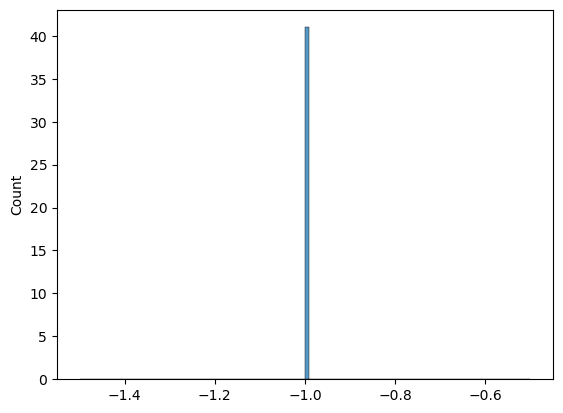

In [61]:
sns.histplot(df_train[(df_train[col_name] < 0) & (df_train[col_name] >= -100)][col_name].values, bins=110)

<Axes: ylabel='Count'>

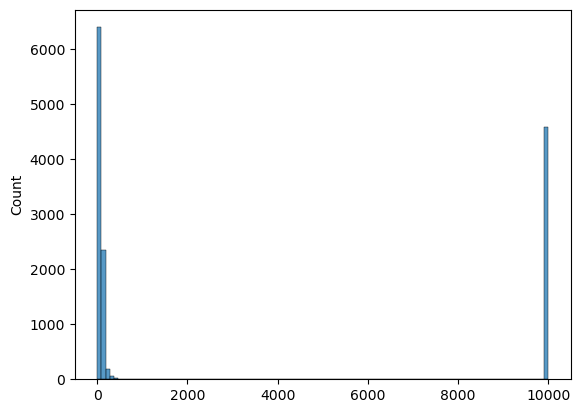

In [62]:
sns.histplot(df_train[(df_train[col_name] > 0)][col_name].values, bins=110)

<Axes: ylabel='Percent'>

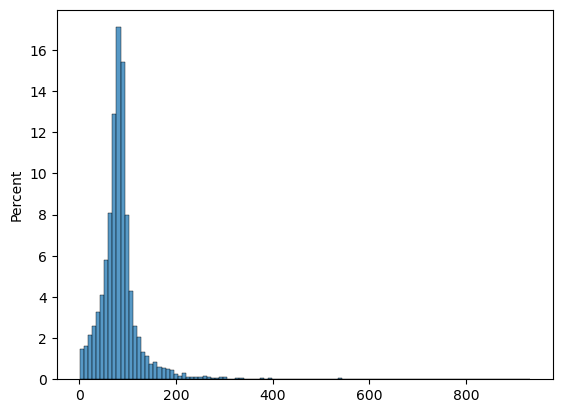

In [63]:
sns.histplot(df_train[(df_train[col_name] > 0) & (df_train[col_name] < 1000)][col_name].values, bins=110, stat='percent')

<Axes: ylabel='Percent'>

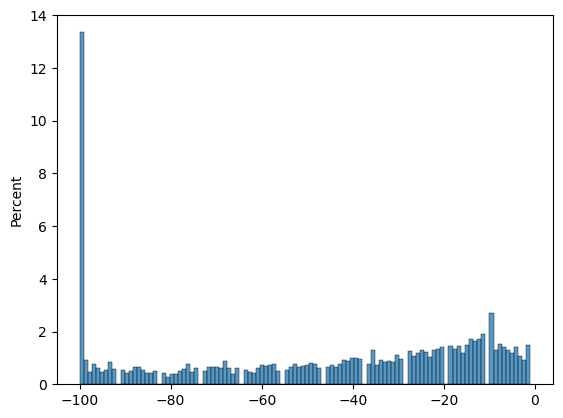

In [64]:
sns.histplot(df_train[(df_train['TRD_B_18'].astype(float) < 0) & (df_train['TRD_B_18'].astype(float) >= -100)]['TRD_B_18'].values, bins=110, stat='percent')

<Axes: ylabel='Percent'>

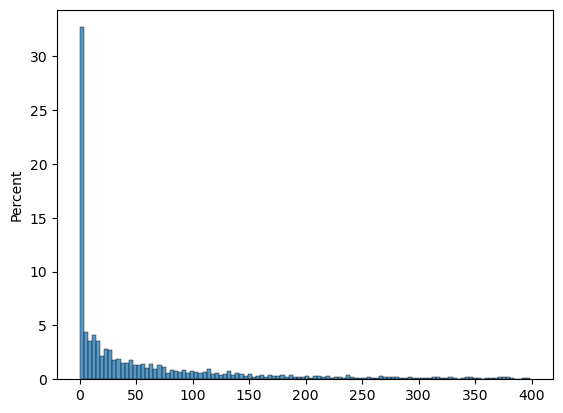

In [65]:
sns.histplot(df_train[(df_train['TRD_B_18'].astype(float) >= 0) & (df_train['TRD_B_18'].astype(float) < 400)]['TRD_B_18'].values, bins=110, stat='percent')

In [66]:
np.sort(df.E4_Q_04   .unique())

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50], dtype=int64)

In [67]:
COLUMNS_SP_SPLITS: Dict[str, Any] = {
    'TRD_B_24':  {
        'special_codes':
        dict(
            zip(
                [
                    -999999,
                    -999998,
                    -999997,
                    -999996,
                    -999995,
                ], 
                [
                    -999999,
                    -999998,
                    -999997,
                    -999996,
                    -999995,
                ]
            )
        ),
        'user_splits': [0 , 50,  100],
        'user_splits_fixed': [True, True, True]
    },
    'TRD_B_20': {
        'special_codes': dict(
            zip(
                [
                    -999999,
                    -999998,
                    -999997,
                    -999996,
                    -999995,
                    -100
                ], 
                [
                    -999999,
                    -999998,
                    -999997,
                    -999996,
                    -999995,
                    -100
                ]
            )
        ),
        'user_splits': [0 ,   450, 800],
        'user_splits_fixed': [True, True, True]
    },
    'SP_B2_18': {
        'special_codes': dict(
            zip(
                [
                    9997,
                    9998,
                    9999,
                    -1
                ], 
                [
                    9997,
                    9998,
                    9999,
                    -1
                ]
            )
        )
    },
    'TRD_B_18': {
        'special_codes': dict(
            zip(
                [
                    -999999,
                    -999998,
                    -999997,
                    -999996,
                    -999995,
                    -999994,
                    
                ], 
                [
                    -999999,
                    -999998,
                    -999997,
                    -999996,
                    -999995,
                    -999994,
                ]
            )
        ),
        'user_splits': [0, 100],
        'user_splits_fixed': [True, True]
    },
    'TRD_B_08': {
        'special_codes': 
            dict(
                zip(
                    [
                        -999999,
                        -999998,
                        -999997,
                        -999996,
                        -999995,
                        -999994,
                    ],
                    [
                        -999999,
                        -999998,
                        -999997,
                        -999996,
                        -999995,
                        -999994,
                    ]
                )
        ),
    'user_splits': [0, 100],
    'user_splits_fixed': [True, True]
    }, 

    'ND_ECC_04': {
        'special_codes': dict(
            zip(
                [
                    -1,
                    997,
                    998,
                    999,
                ],
                [
                    -1,
                    997,
                    998,
                    999,
                ]
            )
        ),
    'user_splits': [5],
    'user_splits_fixed': [True] 
    }
}

In [68]:
np.sort(df.ND_ECC_04.unique())

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  84,  85,  86,  89,  92,  93,  97,  99, 101, 105, 107,
       108, 111, 118, 121, 123, 124, 126, 131, 146, 148, 173, 187, 195,
       202, 209, 263, 267, 289, 998, 999], dtype=int64)

In [69]:
exceptions = []
for col_name in tqdm(COLUMNS_SP_SPLITS.keys()):
    try: 
        unique_vals = df[col_name].unique()
        
        dict_to_replace: Dict[str, float] = dict()
        unique_floats: List[float] = []
        for elem in unique_vals:
            try:
                dict_to_replace[elem] = float(elem)
                unique_floats += [float(elem)]
            except ValueError:
                pass


        optb = OptimalBinning(
            name=col_name, 
            dtype='numerical', 
            solver="mip",
            special_codes=COLUMNS_SP_SPLITS[col_name]['special_codes'],
            monotonic_trend='auto_asc_desc',
            user_splits=COLUMNS_SP_SPLITS[col_name].get('user_splits'),
            user_splits_fixed=COLUMNS_SP_SPLITS[col_name].get('user_splits_fixed'), 
            min_n_bins=len(COLUMNS_SP_SPLITS[col_name]['special_codes']) + \
                sum(COLUMNS_SP_SPLITS[col_name].get('user_splits_fixed') if COLUMNS_SP_SPLITS[col_name].get('user_splits_fixed') is not None else [0]),
            split_digits=0
        )
        optb.fit(df_train[col_name].replace(dict_to_replace).values, df_train[TARGET_BIN_IisB].values)
        df[col_name + 'OptBin'] = optb.transform(df[col_name].replace(dict_to_replace).values, metric="woe")
        df[f'Bin{col_name}'] = optb.transform(df[col_name].replace(dict_to_replace).values, metric="bins")
        dump(optb, os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
        optbins_params = optb.get_params()
        print(optbins_params)
        dump(optbins_params, os.path.join(OPT_BIN_PATH, f'[params]{col_name}-negatives-separately-I-excl.jblb'))
        temp = optb.binning_table.build()
        print(temp)
    except Exception as e:
            exceptions += [(col_name, e)]

 17%|██████████████                                                                      | 1/6 [00:01<00:09,  1.89s/it]

{'cat_cutoff': None, 'cat_unknown': None, 'class_weight': None, 'divergence': 'iv', 'dtype': 'numerical', 'gamma': 0, 'max_bin_n_event': None, 'max_bin_n_nonevent': None, 'max_bin_size': None, 'max_n_bins': None, 'max_n_prebins': 20, 'max_pvalue': None, 'max_pvalue_policy': 'consecutive', 'min_bin_n_event': None, 'min_bin_n_nonevent': None, 'min_bin_size': None, 'min_event_rate_diff': 0, 'min_n_bins': 8, 'min_prebin_size': 0.05, 'mip_solver': 'bop', 'monotonic_trend': 'auto_asc_desc', 'name': 'TRD_B_24', 'outlier_detector': None, 'outlier_params': None, 'prebinning_method': 'cart', 'solver': 'mip', 'special_codes': {-999999: -999999, -999998: -999998, -999997: -999997, -999996: -999996, -999995: -999995}, 'split_digits': 0, 'time_limit': 100, 'user_splits': [0, 50, 100], 'user_splits_fixed': array([ True,  True,  True]), 'verbose': False}
                    Bin  Count  Count (%)  Non-event  Event  Event rate  \
0          (-inf, 0.00)   4722   0.338737       4672     50    0.010589   

 33%|████████████████████████████                                                        | 2/6 [00:07<00:15,  3.92s/it]

{'cat_cutoff': None, 'cat_unknown': None, 'class_weight': None, 'divergence': 'iv', 'dtype': 'numerical', 'gamma': 0, 'max_bin_n_event': None, 'max_bin_n_nonevent': None, 'max_bin_size': None, 'max_n_bins': None, 'max_n_prebins': 20, 'max_pvalue': None, 'max_pvalue_policy': 'consecutive', 'min_bin_n_event': None, 'min_bin_n_nonevent': None, 'min_bin_size': None, 'min_event_rate_diff': 0, 'min_n_bins': 9, 'min_prebin_size': 0.05, 'mip_solver': 'bop', 'monotonic_trend': 'auto_asc_desc', 'name': 'TRD_B_20', 'outlier_detector': None, 'outlier_params': None, 'prebinning_method': 'cart', 'solver': 'mip', 'special_codes': {-999999: -999999, -999998: -999998, -999997: -999997, -999996: -999996, -999995: -999995, -100: -100}, 'split_digits': 0, 'time_limit': 100, 'user_splits': [0, 450, 800], 'user_splits_fixed': array([ True,  True,  True]), 'verbose': False}
                     Bin  Count  Count (%)  Non-event  Event  Event rate  \
0           (-inf, 0.00)   3656   0.262267       3612     44

 50%|██████████████████████████████████████████                                          | 3/6 [00:08<00:07,  2.53s/it]

{'cat_cutoff': None, 'cat_unknown': None, 'class_weight': None, 'divergence': 'iv', 'dtype': 'numerical', 'gamma': 0, 'max_bin_n_event': None, 'max_bin_n_nonevent': None, 'max_bin_size': None, 'max_n_bins': None, 'max_n_prebins': 20, 'max_pvalue': None, 'max_pvalue_policy': 'consecutive', 'min_bin_n_event': None, 'min_bin_n_nonevent': None, 'min_bin_size': None, 'min_event_rate_diff': 0, 'min_n_bins': 4, 'min_prebin_size': 0.05, 'mip_solver': 'bop', 'monotonic_trend': 'auto_asc_desc', 'name': 'SP_B2_18', 'outlier_detector': None, 'outlier_params': None, 'prebinning_method': 'cart', 'solver': 'mip', 'special_codes': {9997: 9997, 9998: 9998, 9999: 9999, -1: -1}, 'split_digits': 0, 'time_limit': 100, 'user_splits': None, 'user_splits_fixed': None, 'verbose': False}
                    Bin  Count  Count (%)  Non-event  Event  Event rate  \
0         (-inf, 82.00)   3397   0.243687       3361     36    0.010598   
1        [82.00, 92.00)   1025   0.073529       1014     11    0.010732   
2 

 67%|████████████████████████████████████████████████████████                            | 4/6 [00:12<00:06,  3.12s/it]

{'cat_cutoff': None, 'cat_unknown': None, 'class_weight': None, 'divergence': 'iv', 'dtype': 'numerical', 'gamma': 0, 'max_bin_n_event': None, 'max_bin_n_nonevent': None, 'max_bin_size': None, 'max_n_bins': None, 'max_n_prebins': 20, 'max_pvalue': None, 'max_pvalue_policy': 'consecutive', 'min_bin_n_event': None, 'min_bin_n_nonevent': None, 'min_bin_size': None, 'min_event_rate_diff': 0, 'min_n_bins': 8, 'min_prebin_size': 0.05, 'mip_solver': 'bop', 'monotonic_trend': 'auto_asc_desc', 'name': 'TRD_B_18', 'outlier_detector': None, 'outlier_params': None, 'prebinning_method': 'cart', 'solver': 'mip', 'special_codes': {-999999: -999999, -999998: -999998, -999997: -999997, -999996: -999996, -999995: -999995, -999994: -999994}, 'split_digits': 0, 'time_limit': 100, 'user_splits': [0, 100], 'user_splits_fixed': array([ True,  True]), 'verbose': False}
                   Bin  Count  Count (%)  Non-event  Event  Event rate  \
0         (-inf, 0.00)   5431   0.389598       5355     76    0.0139

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:18<00:00,  2.95s/it]

{'cat_cutoff': None, 'cat_unknown': None, 'class_weight': None, 'divergence': 'iv', 'dtype': 'numerical', 'gamma': 0, 'max_bin_n_event': None, 'max_bin_n_nonevent': None, 'max_bin_size': None, 'max_n_bins': None, 'max_n_prebins': 20, 'max_pvalue': None, 'max_pvalue_policy': 'consecutive', 'min_bin_n_event': None, 'min_bin_n_nonevent': None, 'min_bin_size': None, 'min_event_rate_diff': 0, 'min_n_bins': 8, 'min_prebin_size': 0.05, 'mip_solver': 'bop', 'monotonic_trend': 'auto_asc_desc', 'name': 'TRD_B_08', 'outlier_detector': None, 'outlier_params': None, 'prebinning_method': 'cart', 'solver': 'mip', 'special_codes': {-999999: -999999, -999998: -999998, -999997: -999997, -999996: -999996, -999995: -999995, -999994: -999994}, 'split_digits': 0, 'time_limit': 100, 'user_splits': [0, 100], 'user_splits_fixed': array([ True,  True]), 'verbose': False}
                   Bin  Count  Count (%)  Non-event  Event  Event rate  \
0         (-inf, 0.00)   5201   0.373099       5109     92    0.0176

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:18<00:00,  3.15s/it]


In [70]:
print('If any Exception: ', len(exceptions))

If any Exception:  0


## WoE per bin

In [71]:
COLS_INTER = [
    'SP_EDI_24',
    'E4_Q_17',
    'TRD_A_20',
    'SP_I_67_01',
    'ND_ERL_01',
    'ND_HAC_06',
    'SP_B2_20',
    'TRD_B_24',
    'TRD_B_20',
    'SP_B2_18',
    'TRD_B_18',
    'TRD_B_08',
    'ND_ECC_04'
]

In [72]:
def find_max_of_negative_bins(x):
    v: Union[float, np.nan] = np.nan
    try: 
        v = float(x)
        return v
    except:
        return np.nan

In [73]:
#  extract intervals
warnings.filterwarnings("ignore", category=FutureWarning)
df_intervals = pd.DataFrame()
for col_name in COLUMNS_DICT.keys():
    optb = load(os.path.join(OPT_BIN_PATH, f'{col_name}-negatives-separately-I-excl.jblb'))
    temp = optb.binning_table.build()
    temp['Feature'] = col_name
    temp.Bin = temp.Bin.astype(str)
    temp = temp[~((temp.Bin == 'Missing') & (temp.Count == 0))]
    temp = temp[(temp.Bin != '')]
    temp = temp.reset_index(drop=True)
    df_intervals = pd.concat((df_intervals, temp))

In [74]:
df_intervals.head()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature
0,"(-inf, 684.50)",1327,0.095194,1145,182,0.137151,-1.60585,0.541999,0.061296,OPTIN_11SCN_ML
1,"[684.50, 760.50)",1100,0.078910,1001,99,0.090000,-1.131368,0.176040,0.020902,OPTIN_11SCN_ML
2,"[760.50, 814.50)",845,0.060617,796,49,0.057988,-0.657224,0.035993,0.004420,OPTIN_11SCN_ML
3,"[814.50, 859.50)",699,0.050143,676,23,0.032904,-0.064304,0.000214,0.000027,OPTIN_11SCN_ML
4,"[859.50, 955.50)",1661,0.119154,1627,34,0.020470,0.423129,0.017582,0.002181,OPTIN_11SCN_ML


In [75]:
df_intervals_st = df_intervals[~df_intervals.Feature.isin(COLS_INTER)].reset_index(drop=True).copy()
df_intervals_mod = df_intervals[df_intervals.Feature.isin(COLS_INTER)].reset_index(drop=True).copy()

In [76]:
temp = df_intervals_st.groupby('Feature').apply(lambda y: y.Bin.apply(lambda x: float(find_max_of_negative_bins(x))).astype(float).max()).reset_index(name='min_val')
df_intervals_st = pd.merge(df_intervals_st, temp, on='Feature', how='left')
df_intervals_st['Bin'] = df_intervals_st.apply(lambda x: x.Bin.replace('(-inf', '(' + str(x.min_val)) if not np.isnan(x.min_val) else x.Bin, axis=1)
del df_intervals_st['min_val']
df_intervals_st

C:\Users\hdychko\AppData\Local\Temp\ipykernel_12576\4025125238.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp = df_intervals_st.groupby('Feature').apply(lambda y: y.Bin.apply(lambda x: float(find_max_of_negative_bins(x))).astype(float).max()).reset_index(name='min_val')


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature
0,"(-997.0, 684.50)",1327,0.095194,1145,182,0.137151,-1.60585,0.541999,0.061296,OPTIN_11SCN_ML
1,"[684.50, 760.50)",1100,0.078910,1001,99,0.090000,-1.131368,0.176040,0.020902,OPTIN_11SCN_ML
2,"[760.50, 814.50)",845,0.060617,796,49,0.057988,-0.657224,0.035993,0.004420,OPTIN_11SCN_ML
3,"[814.50, 859.50)",699,0.050143,676,23,0.032904,-0.064304,0.000214,0.000027,OPTIN_11SCN_ML
4,"[859.50, 955.50)",1661,0.119154,1627,34,0.020470,0.423129,0.017582,0.002181,OPTIN_11SCN_ML
...,...,...,...,...,...,...,...,...,...,...
16060,['Y'],911,0.065352,868,43,0.047201,-0.440012,0.015627,0.001938,EA4_Q_06
16061,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,EA4_Q_06
16062,"(-1.0, inf)",3330,0.238881,3179,151,0.045345,-0.397961,0.045775,0.005684,VM03_SP_VM2_26
16063,-2.0,10569,0.758178,10289,280,0.026493,0.159038,0.017810,0.002224,VM03_SP_VM2_26


In [77]:
COLS_INTER

['SP_EDI_24',
 'E4_Q_17',
 'TRD_A_20',
 'SP_I_67_01',
 'ND_ERL_01',
 'ND_HAC_06',
 'SP_B2_20',
 'TRD_B_24',
 'TRD_B_20',
 'SP_B2_18',
 'TRD_B_18',
 'TRD_B_08',
 'ND_ECC_04']

In [78]:
df_intervals_mod['Bin_init'] = df_intervals_mod['Bin'].copy()

#### SP_EDI_24

In [79]:
df_intervals_mod[df_intervals_mod.Feature == 'SP_EDI_24']

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
5,[5],1848,0.132568,1838,10,0.005411,1.768845,0.199624,0.022137,SP_EDI_24,[5]
6,"(-1, 6)",42,0.003013,42,0,0.000000,0.0,0.000000,0.000000,SP_EDI_24,"(-1, 6)"
7,"(1, 2)",5559,0.398780,5268,291,0.052348,-0.548921,0.156559,0.019328,SP_EDI_24,"(1, 2)"
8,4,6491,0.465638,6361,130,0.020028,0.445403,0.075383,0.009346,SP_EDI_24,4


In [80]:
df_intervals_mod.loc[df_intervals_mod.Feature == 'SP_EDI_24', 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == 'SP_EDI_24'].Bin.replace(
    {
        '[5]': '{5}',
        '(-1, 6)': '{-1, 6}',
        '(1, 2)': '{1, 2}',
        '4': '{4}'
    }
)

In [81]:
df_intervals_mod[df_intervals_mod.Feature == 'SP_EDI_24']

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
5,{5},1848,0.132568,1838,10,0.005411,1.768845,0.199624,0.022137,SP_EDI_24,[5]
6,"{-1, 6}",42,0.003013,42,0,0.000000,0.0,0.000000,0.000000,SP_EDI_24,"(-1, 6)"
7,"{1, 2}",5559,0.398780,5268,291,0.052348,-0.548921,0.156559,0.019328,SP_EDI_24,"(1, 2)"
8,{4},6491,0.465638,6361,130,0.020028,0.445403,0.075383,0.009346,SP_EDI_24,4


#### E4_Q_17

In [82]:
df_intervals_mod[df_intervals_mod.Feature == 'E4_Q_17']

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
18,[6],2744,0.196844,2648,96,0.034985,-0.127792,0.003415,0.000427,E4_Q_17,[6]
19,2,8286,0.594405,8180,106,0.012793,0.901005,0.323986,0.039182,E4_Q_17,2
20,"(1, 5)",243,0.017432,229,14,0.057613,-0.650339,0.010100,0.001241,E4_Q_17,"(1, 5)"
21,"(3, 4, 7, 8)",2667,0.191320,2452,215,0.080615,-1.010982,0.320816,0.038477,E4_Q_17,"(3, 4, 7, 8)"


In [83]:
df_intervals_mod.loc[df_intervals_mod.Feature == 'E4_Q_17', 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == 'E4_Q_17'].Bin.replace(
    {
        '[6]': '{6}',
        '(1, 5)': '{1, 5}',
        '(3, 4, 7, 8)': '{3, 4, 7, 8}',
        '2': '{2}'
    }
).values

In [84]:
df_intervals_mod[df_intervals_mod.Feature == 'E4_Q_17']

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
18,{6},2744,0.196844,2648,96,0.034985,-0.127792,0.003415,0.000427,E4_Q_17,[6]
19,{2},8286,0.594405,8180,106,0.012793,0.901005,0.323986,0.039182,E4_Q_17,2
20,"{1, 5}",243,0.017432,229,14,0.057613,-0.650339,0.010100,0.001241,E4_Q_17,"(1, 5)"
21,"{3, 4, 7, 8}",2667,0.191320,2452,215,0.080615,-1.010982,0.320816,0.038477,E4_Q_17,"(3, 4, 7, 8)"


#### TRD_A_20

In [85]:
col_name = 'TRD_A_20'

In [86]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
0,"(-inf, 6.00)",158,0.011334,155,3,0.018987,0.49981,0.002256,0.000279,TRD_A_20,"(-inf, 6.00)"
1,"[6.00, inf)",307,0.022023,302,5,0.016287,0.655986,0.007055,0.000866,TRD_A_20,"[6.00, inf)"
2,"{-3, 0}",5977,0.428766,5932,45,0.007529,1.436451,0.480789,0.055412,TRD_A_20,"{-3, 0}"
3,-2,7457,0.534935,7079,378,0.050691,-0.51501,0.181803,0.022478,TRD_A_20,-2
4,-1,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000,TRD_A_20,-1


In [87]:
df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.values

array(['(-inf, 6.00)', '[6.00, inf)', '{-3, 0}', '-2', '-1'], dtype=object)

In [88]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.replace(
    {
        '(-inf, 6.00)': '(0, 6)',
        '[6.00, inf)': '[6, inf)',
        '-2': '{-2}',
        '-1': '{-1}'
    }
).values

In [89]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
0,"(0, 6)",158,0.011334,155,3,0.018987,0.49981,0.002256,0.000279,TRD_A_20,"(-inf, 6.00)"
1,"[6, inf)",307,0.022023,302,5,0.016287,0.655986,0.007055,0.000866,TRD_A_20,"[6.00, inf)"
2,"{-3, 0}",5977,0.428766,5932,45,0.007529,1.436451,0.480789,0.055412,TRD_A_20,"{-3, 0}"
3,{-2},7457,0.534935,7079,378,0.050691,-0.51501,0.181803,0.022478,TRD_A_20,-2
4,{-1},41,0.002941,41,0,0.000000,0.0,0.000000,0.000000,TRD_A_20,-1


#### SP_I_67_01

In [90]:
col_name = 'SP_I_67_01'

In [91]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
58,['R'],1788,0.128264,1781,7,0.003915,2.094017,0.242062,0.025714,SP_I_67_01,['R']
59,['X'],2335,0.167504,2256,79,0.033833,-0.093103,0.001517,0.000190,SP_I_67_01,['X']
60,['G'],8994,0.645194,8652,342,0.038025,-0.214268,0.032792,0.004091,SP_I_67_01,['G']
61,[A],782,0.056098,779,3,0.003836,2.114395,0.107210,0.011357,SP_I_67_01,[A]
62,[T],41,0.002941,41,0,0.000000,0.0,0.000000,0.000000,SP_I_67_01,[T]


#### ND_ERL_01

In [92]:
col_name = 'ND_ERL_01'

In [93]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
75,[0],10175,0.729914,9931,244,0.023980,0.261245,0.044154,0.005504,ND_ERL_01,[0]
76,[2],3276,0.235007,3121,155,0.047314,-0.44252,0.056907,0.007056,ND_ERL_01,[2]
77,-1,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000,ND_ERL_01,-1
78,-3,115,0.008250,110,5,0.043478,-0.353961,0.001224,0.000152,ND_ERL_01,-3
79,-4,1,0.000072,1,0,0.000000,0.0,0.000000,0.000000,ND_ERL_01,-4
80,-2,1,0.000072,1,0,0.000000,0.0,0.000000,0.000000,ND_ERL_01,-2
81,[1],331,0.023745,304,27,0.081571,-1.023812,0.041097,0.004924,ND_ERL_01,[1]


In [94]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = '{' + df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.str.replace('[', '').str.replace(']', '') + '}'

In [95]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
75,{0},10175,0.729914,9931,244,0.023980,0.261245,0.044154,0.005504,ND_ERL_01,[0]
76,{2},3276,0.235007,3121,155,0.047314,-0.44252,0.056907,0.007056,ND_ERL_01,[2]
77,{-1},41,0.002941,41,0,0.000000,0.0,0.000000,0.000000,ND_ERL_01,-1
78,{-3},115,0.008250,110,5,0.043478,-0.353961,0.001224,0.000152,ND_ERL_01,-3
79,{-4},1,0.000072,1,0,0.000000,0.0,0.000000,0.000000,ND_ERL_01,-4
80,{-2},1,0.000072,1,0,0.000000,0.0,0.000000,0.000000,ND_ERL_01,-2
81,{1},331,0.023745,304,27,0.081571,-1.023812,0.041097,0.004924,ND_ERL_01,[1]


#### ND_HAC_06

In [96]:
col_name='ND_HAC_06'

In [97]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
82,[0],10278,0.737303,9895,383,0.037264,-0.193253,0.030178,0.003766,ND_HAC_06,[0]
83,"[7, 8, 9, 10, 11, 12]",13,0.000933,10,3,0.230769,-2.241031,0.013940,0.001450,ND_HAC_06,"[7, 8, 9, 10, 11, 12]"
84,[1. 3. 5. 6.],3608,0.258824,3563,45,0.012472,0.926692,0.147661,0.017824,ND_HAC_06,[1. 3. 5. 6.]
85,-1,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000,ND_HAC_06,-1


In [98]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.replace(
    {
        '-1': '[-1]'
    }
).values

In [99]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
82,[0],10278,0.737303,9895,383,0.037264,-0.193253,0.030178,0.003766,ND_HAC_06,[0]
83,"[7, 8, 9, 10, 11, 12]",13,0.000933,10,3,0.230769,-2.241031,0.013940,0.001450,ND_HAC_06,"[7, 8, 9, 10, 11, 12]"
84,[1. 3. 5. 6.],3608,0.258824,3563,45,0.012472,0.926692,0.147661,0.017824,ND_HAC_06,[1. 3. 5. 6.]
85,[-1],41,0.002941,41,0,0.000000,0.0,0.000000,0.000000,ND_HAC_06,-1


In [100]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = '{' + df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.str.replace('[', '').str.replace(']', '').str.replace('.', ',') + '}'

In [101]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
82,{0},10278,0.737303,9895,383,0.037264,-0.193253,0.030178,0.003766,ND_HAC_06,[0]
83,"{7, 8, 9, 10, 11, 12}",13,0.000933,10,3,0.230769,-2.241031,0.013940,0.001450,ND_HAC_06,"[7, 8, 9, 10, 11, 12]"
84,"{1, 3, 5, 6,}",3608,0.258824,3563,45,0.012472,0.926692,0.147661,0.017824,ND_HAC_06,[1. 3. 5. 6.]
85,{-1},41,0.002941,41,0,0.000000,0.0,0.000000,0.000000,ND_HAC_06,-1


#### SP_B2_20


In [102]:
col_name = 'SP_B2_20'

In [103]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
63,"(-inf, 38.00)",1107,0.079412,1091,16,0.014453,0.777258,0.033918,0.004136,SP_B2_20,"(-inf, 38.00)"
64,"[38.00, 94.00)",5829,0.418149,5726,103,0.017670,0.57304,0.105947,0.013065,SP_B2_20,"[38.00, 94.00)"
65,"[94.00, inf)",2411,0.172956,2353,58,0.024056,0.258,0.010219,0.001274,SP_B2_20,"[94.00, inf)"
66,9997,78,0.005595,67,11,0.141026,-1.638206,0.033685,0.003795,SP_B2_20,9997
67,9998,4487,0.321879,4245,242,0.053934,-0.580444,0.143515,0.017692,SP_B2_20,9998
68,9999,28,0.002009,27,1,0.035714,-0.149166,0.000048,0.000006,SP_B2_20,9999


In [104]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.str.replace('(-inf', '[0')

In [105]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.str.replace('inf)', '9996]')

In [106]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
63,"[0, 38.00)",1107,0.079412,1091,16,0.014453,0.777258,0.033918,0.004136,SP_B2_20,"(-inf, 38.00)"
64,"[38.00, 94.00)",5829,0.418149,5726,103,0.017670,0.57304,0.105947,0.013065,SP_B2_20,"[38.00, 94.00)"
65,"[94.00, 9996]",2411,0.172956,2353,58,0.024056,0.258,0.010219,0.001274,SP_B2_20,"[94.00, inf)"
66,9997,78,0.005595,67,11,0.141026,-1.638206,0.033685,0.003795,SP_B2_20,9997
67,9998,4487,0.321879,4245,242,0.053934,-0.580444,0.143515,0.017692,SP_B2_20,9998
68,9999,28,0.002009,27,1,0.035714,-0.149166,0.000048,0.000006,SP_B2_20,9999


#### TRD_B_24

In [107]:
col_name = 'TRD_B_24'

In [108]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
9,"(-inf, 0.00)",4722,0.338737,4672,50,0.010589,1.092316,0.251052,0.029909,TRD_B_24,"(-inf, 0.00)"
10,"[0.00, 50.00)",3974,0.285079,3861,113,0.028435,0.08629,0.002039,0.000255,TRD_B_24,"[0.00, 50.00)"
11,"[50.00, 100.00)",1148,0.082353,1127,21,0.018293,0.537789,0.018662,0.002305,TRD_B_24,"[50.00, 100.00)"
12,"[100.00, inf)",1563,0.112123,1541,22,0.014075,0.804141,0.050683,0.006170,TRD_B_24,"[100.00, inf)"
13,-999999,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000,TRD_B_24,-999999
14,-999998,2094,0.150215,1929,165,0.078797,-0.986192,0.236722,0.028447,TRD_B_24,-999998
15,-999997,398,0.028551,338,60,0.150754,-1.716302,0.195986,0.021875,TRD_B_24,-999997
16,-999996,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,TRD_B_24,-999996
17,-999995,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,TRD_B_24,-999995


In [109]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.str.replace('(-inf', '[-100')

In [110]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
9,"[-100, 0.00)",4722,0.338737,4672,50,0.010589,1.092316,0.251052,0.029909,TRD_B_24,"(-inf, 0.00)"
10,"[0.00, 50.00)",3974,0.285079,3861,113,0.028435,0.08629,0.002039,0.000255,TRD_B_24,"[0.00, 50.00)"
11,"[50.00, 100.00)",1148,0.082353,1127,21,0.018293,0.537789,0.018662,0.002305,TRD_B_24,"[50.00, 100.00)"
12,"[100.00, inf)",1563,0.112123,1541,22,0.014075,0.804141,0.050683,0.006170,TRD_B_24,"[100.00, inf)"
13,-999999,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000,TRD_B_24,-999999
14,-999998,2094,0.150215,1929,165,0.078797,-0.986192,0.236722,0.028447,TRD_B_24,-999998
15,-999997,398,0.028551,338,60,0.150754,-1.716302,0.195986,0.021875,TRD_B_24,-999997
16,-999996,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,TRD_B_24,-999996
17,-999995,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,TRD_B_24,-999995


#### TRD_B_20

In [111]:
col_name = 'TRD_B_20'

In [112]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
22,"(-inf, 0.00)",3656,0.262267,3612,44,0.012035,0.962824,0.159144,0.019159,TRD_B_20,"(-inf, 0.00)"
23,"[0.00, 450.00)",4406,0.316069,4340,66,0.014980,0.740972,0.124583,0.015226,TRD_B_20,"[0.00, 450.00)"
24,"[450.00, 800.00)",358,0.025681,352,6,0.016760,0.626868,0.007607,0.000936,TRD_B_20,"[450.00, 800.00)"
25,"[800.00, inf)",793,0.056887,767,26,0.032787,-0.060613,0.000215,0.000027,TRD_B_20,"[800.00, inf)"
26,-999999,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000,TRD_B_20,-999999
27,-999998,1904,0.136585,1747,157,0.082458,-1.035594,0.243311,0.029124,TRD_B_20,-999998
28,-999997,398,0.028551,338,60,0.150754,-1.716302,0.195986,0.021875,TRD_B_20,-999997
29,-999996,1536,0.110187,1474,62,0.040365,-0.276403,0.009602,0.001196,TRD_B_20,-999996
30,-999995,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,TRD_B_20,-999995
31,-100,848,0.060832,838,10,0.011792,0.98343,0.038187,0.004590,TRD_B_20,-100


In [113]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.str.replace('(-inf', '(-100')

In [114]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
22,"(-100, 0.00)",3656,0.262267,3612,44,0.012035,0.962824,0.159144,0.019159,TRD_B_20,"(-inf, 0.00)"
23,"[0.00, 450.00)",4406,0.316069,4340,66,0.014980,0.740972,0.124583,0.015226,TRD_B_20,"[0.00, 450.00)"
24,"[450.00, 800.00)",358,0.025681,352,6,0.016760,0.626868,0.007607,0.000936,TRD_B_20,"[450.00, 800.00)"
25,"[800.00, inf)",793,0.056887,767,26,0.032787,-0.060613,0.000215,0.000027,TRD_B_20,"[800.00, inf)"
26,-999999,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000,TRD_B_20,-999999
27,-999998,1904,0.136585,1747,157,0.082458,-1.035594,0.243311,0.029124,TRD_B_20,-999998
28,-999997,398,0.028551,338,60,0.150754,-1.716302,0.195986,0.021875,TRD_B_20,-999997
29,-999996,1536,0.110187,1474,62,0.040365,-0.276403,0.009602,0.001196,TRD_B_20,-999996
30,-999995,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,TRD_B_20,-999995
31,-100,848,0.060832,838,10,0.011792,0.98343,0.038187,0.004590,TRD_B_20,-100


#### SP_B2_18

In [115]:
col_name = 'SP_B2_18'

In [116]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
32,"(-inf, 82.00)",3397,0.243687,3361,36,0.010598,1.091472,0.180388,0.021492,SP_B2_18,"(-inf, 82.00)"
33,"[82.00, 92.00)",1025,0.073529,1014,11,0.010732,1.07876,0.053441,0.006374,SP_B2_18,"[82.00, 92.00)"
34,"[92.00, 156.00)",2436,0.174749,2397,39,0.016010,0.673408,0.058553,0.007184,SP_B2_18,"[92.00, 156.00)"
35,"[156.00, inf)",698,0.050072,684,14,0.020057,0.443897,0.008057,0.000999,SP_B2_18,"[156.00, inf)"
36,9997,576,0.041320,520,56,0.097222,-1.216526,0.111236,0.013106,SP_B2_18,9997
37,9998,5066,0.363415,4880,186,0.036715,-0.177849,0.012505,0.001561,SP_B2_18,9998
38,9999,701,0.050287,612,89,0.126961,-1.516907,0.244515,0.027935,SP_B2_18,9999
39,-1,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000,SP_B2_18,-1


In [117]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.str.replace('(-inf', '[0')

In [118]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.str.replace('inf)', '9996]')

In [119]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
32,"[0, 82.00)",3397,0.243687,3361,36,0.010598,1.091472,0.180388,0.021492,SP_B2_18,"(-inf, 82.00)"
33,"[82.00, 92.00)",1025,0.073529,1014,11,0.010732,1.07876,0.053441,0.006374,SP_B2_18,"[82.00, 92.00)"
34,"[92.00, 156.00)",2436,0.174749,2397,39,0.016010,0.673408,0.058553,0.007184,SP_B2_18,"[92.00, 156.00)"
35,"[156.00, 9996]",698,0.050072,684,14,0.020057,0.443897,0.008057,0.000999,SP_B2_18,"[156.00, inf)"
36,9997,576,0.041320,520,56,0.097222,-1.216526,0.111236,0.013106,SP_B2_18,9997
37,9998,5066,0.363415,4880,186,0.036715,-0.177849,0.012505,0.001561,SP_B2_18,9998
38,9999,701,0.050287,612,89,0.126961,-1.516907,0.244515,0.027935,SP_B2_18,9999
39,-1,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000,SP_B2_18,-1


#### TRD_B_18

In [120]:
col_name = 'TRD_B_18'

In [121]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
40,"(-inf, 0.00)",5431,0.389598,5355,76,0.013994,0.810049,0.178266,0.021693,TRD_B_18,"(-inf, 0.00)"
41,"[0.00, 100.00)",4306,0.308895,4188,118,0.027404,0.124291,0.004504,0.000563,TRD_B_18,"[0.00, 100.00)"
42,"[100.00, inf)",1899,0.136227,1859,40,0.021064,0.393911,0.017649,0.002192,TRD_B_18,"[100.00, inf)"
43,-999999,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000,TRD_B_18,-999999
44,-999998,856,0.061406,774,82,0.095794,-1.200151,0.159572,0.018829,TRD_B_18,-999998
45,-999997,398,0.028551,338,60,0.150754,-1.716302,0.195986,0.021875,TRD_B_18,-999997
46,-999996,1009,0.072382,954,55,0.054509,-0.591673,0.033720,0.004155,TRD_B_18,-999996
47,-999995,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,TRD_B_18,-999995
48,-999994,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,TRD_B_18,-999994


In [122]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.str.replace('(-inf', '[-100')

In [123]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
40,"[-100, 0.00)",5431,0.389598,5355,76,0.013994,0.810049,0.178266,0.021693,TRD_B_18,"(-inf, 0.00)"
41,"[0.00, 100.00)",4306,0.308895,4188,118,0.027404,0.124291,0.004504,0.000563,TRD_B_18,"[0.00, 100.00)"
42,"[100.00, inf)",1899,0.136227,1859,40,0.021064,0.393911,0.017649,0.002192,TRD_B_18,"[100.00, inf)"
43,-999999,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000,TRD_B_18,-999999
44,-999998,856,0.061406,774,82,0.095794,-1.200151,0.159572,0.018829,TRD_B_18,-999998
45,-999997,398,0.028551,338,60,0.150754,-1.716302,0.195986,0.021875,TRD_B_18,-999997
46,-999996,1009,0.072382,954,55,0.054509,-0.591673,0.033720,0.004155,TRD_B_18,-999996
47,-999995,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,TRD_B_18,-999995
48,-999994,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,TRD_B_18,-999994


#### TRD_B_08

In [124]:
col_name = 'TRD_B_08'

In [125]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
49,"(-inf, 0.00)",5201,0.373099,5109,92,0.017689,0.571967,0.094223,0.011620,TRD_B_08,"(-inf, 0.00)"
50,"[0.00, 100.00)",2931,0.210258,2841,90,0.030706,0.007098,0.000011,0.000001,TRD_B_08,"[0.00, 100.00)"
51,"[100.00, inf)",3452,0.247633,3360,92,0.026651,0.152904,0.005392,0.000673,TRD_B_08,"[100.00, inf)"
52,-999999,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000,TRD_B_08,-999999
53,-999998,568,0.040746,512,56,0.098592,-1.23203,0.113383,0.013339,TRD_B_08,-999998
54,-999997,18,0.001291,18,0,0.000000,0.0,0.000000,0.000000,TRD_B_08,-999997
55,-999996,1729,0.124032,1628,101,0.058415,-0.665016,0.075696,0.009291,TRD_B_08,-999996
56,-999995,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,TRD_B_08,-999995
57,-999994,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,TRD_B_08,-999994


In [126]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.str.replace('(-inf', '[-100')

In [127]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
49,"[-100, 0.00)",5201,0.373099,5109,92,0.017689,0.571967,0.094223,0.011620,TRD_B_08,"(-inf, 0.00)"
50,"[0.00, 100.00)",2931,0.210258,2841,90,0.030706,0.007098,0.000011,0.000001,TRD_B_08,"[0.00, 100.00)"
51,"[100.00, inf)",3452,0.247633,3360,92,0.026651,0.152904,0.005392,0.000673,TRD_B_08,"[100.00, inf)"
52,-999999,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000,TRD_B_08,-999999
53,-999998,568,0.040746,512,56,0.098592,-1.23203,0.113383,0.013339,TRD_B_08,-999998
54,-999997,18,0.001291,18,0,0.000000,0.0,0.000000,0.000000,TRD_B_08,-999997
55,-999996,1729,0.124032,1628,101,0.058415,-0.665016,0.075696,0.009291,TRD_B_08,-999996
56,-999995,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,TRD_B_08,-999995
57,-999994,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,TRD_B_08,-999994


#### ND_ECC_04

In [128]:
col_name = 'ND_ECC_04'

In [129]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
69,"(-inf, 5.00)",822,0.058967,729,93,0.113139,-1.385929,0.224262,0.025985,ND_ECC_04,"(-inf, 5.00)"
70,"[5.00, inf)",532,0.038164,518,14,0.026316,0.165915,0.000973,0.000121,ND_ECC_04,"[5.00, inf)"
71,-1,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000,ND_ECC_04,-1
72,997,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,ND_ECC_04,997
73,998,1202,0.086227,1131,71,0.059068,-0.676826,0.054830,0.006726,ND_ECC_04,998
74,999,11343,0.813702,11090,253,0.022305,0.335406,0.078461,0.009762,ND_ECC_04,999


In [130]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.str.replace('(-inf', '[0')

In [131]:
df_intervals_mod.loc[df_intervals_mod.Feature == col_name, 'Bin'] = df_intervals_mod[df_intervals_mod.Feature == col_name].Bin.str.replace('inf)', '996]')

In [132]:
df_intervals_mod[df_intervals_mod.Feature == col_name]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
69,"[0, 5.00)",822,0.058967,729,93,0.113139,-1.385929,0.224262,0.025985,ND_ECC_04,"(-inf, 5.00)"
70,"[5.00, 996]",532,0.038164,518,14,0.026316,0.165915,0.000973,0.000121,ND_ECC_04,"[5.00, inf)"
71,-1,41,0.002941,41,0,0.000000,0.0,0.000000,0.000000,ND_ECC_04,-1
72,997,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,ND_ECC_04,997
73,998,1202,0.086227,1131,71,0.059068,-0.676826,0.054830,0.006726,ND_ECC_04,998
74,999,11343,0.813702,11090,253,0.022305,0.335406,0.078461,0.009762,ND_ECC_04,999


In [133]:
for feat in COLS_INTER:
    temp = df_intervals_mod[df_intervals_mod.Feature == feat][['Bin', 'Bin_init']]
    temp = temp[~temp.duplicated()].set_index('Bin_init')
    dict_to_repl = temp.to_dict(orient='dict')['Bin']
    # df[f'Bin{feat}'] = df[f'Bin{feat}'].replace(dict_to_repl)

In [134]:
df_intervals = pd.concat((df_intervals_mod, df_intervals_st)).reset_index(drop=True)

## Check

In [135]:
np.random.seed(RANDOM_SEED)
random_col = np.random.choice(list(COLUMNS_DICT.keys()), 1)[0]
df_intervals[df_intervals.Feature == random_col]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
13236,[ 49. 236. 238. 239. 240. 241. 242. 243. 244. ...,2892,0.207461,2888,4,0.001383,3.137022,0.641529,0.058012,SP_EDI_17,NaN
13237,[160. 128. 147. 167. 134. 122.],766,0.054950,753,13,0.016971,0.614113,0.015708,0.001933,SP_EDI_17,NaN
13238,[149. 151. 104. 141. 123. 130. 181.],841,0.060330,822,19,0.022592,0.322298,0.005403,0.000672,SP_EDI_17,NaN
13239,[148. 170. 162. 204. 143. 103. 177.],778,0.055811,757,21,0.026992,0.139837,0.001023,0.000128,SP_EDI_17,NaN
13240,[142. 163. 145. 210. 191. 156. 153. 124. 132. ...,1313,0.094189,1274,39,0.029703,0.041352,0.000158,0.000020,SP_EDI_17,NaN
13241,[183. 158. 155. 131. 168. 217. 138. 202. 127. ...,1106,0.079340,1069,37,0.033454,-0.081442,0.000547,0.000068,SP_EDI_17,NaN
13242,[237. 137. 139. 144. 172. 164. 146. 249. 247. ...,1071,0.076829,1029,42,0.039216,-0.24633,0.005241,0.000653,SP_EDI_17,NaN
13243,[185. 118. 150. 208. 105. 159. 152. 100. 129.],916,0.065710,876,40,0.043668,-0.358517,0.010025,0.001246,SP_EDI_17,NaN
13244,[120. 113. 111. 135. 184. 211. 214. 112. 99. ...,828,0.059397,787,41,0.049517,-0.490347,0.018079,0.002238,SP_EDI_17,NaN
13245,[115. 136. 199. 91. 108. 126. 116. 203. 197. ...,824,0.059110,777,47,0.057039,-0.639711,0.032965,0.004052,SP_EDI_17,NaN


In [136]:
df_train[df_train[random_col] == -2].shape

(1793, 1775)

In [137]:
df_train[df_train[random_col] == -2][TARGET_NAME].value_counts()

GB6_Flag_2Limit
G    1735
B      58
Name: count, dtype: int64

In [138]:
df_train[df_train[random_col] == -2][TARGET_BIN_IisB].value_counts()

_GB6_Flag_2Limit_bin_IisB
0    1735
1      58
Name: count, dtype: int64

In [139]:
df_intervals.to_csv('bins_optbins_neg_sep_I_excl.csv')

In [140]:
COLS_TO_SAVE = [
'OPTIN_11SCN_MLOptBin',
'G5_ND_SPECIIOptBin',
'Marital_StatusOptBin',
'SP_F2_33OptBin',
'AFF_B_09_01OptBin',
'TRD_A_20OptBin',
'TRD_A_08OptBin',
'VM01_SP_VM2_15OptBin',
'GEN11_SP_N_92OptBin',
'SP_EDI_24OptBin',
'SP_G_37OptBin',
'E4_Q_17OptBin',
'TRD_C_07OptBin',
'TRD_B_20OptBin',
'SP_B2_18OptBin',
'SPA_F2_33OptBin',
'VM01_SP_VM2_14OptBin',
'VM01_SP_VM2_24OptBin',
'SP_G_38OptBin',
'TRD_O_05OptBin',
'E1_A_09OptBin',
'TRD_O_07OptBin',
'ND_INC_03OptBin',
'VM01_SP_VM2_17OptBin',
'SP_B1_14OptBin',
'GEN11_SP_N_91OptBin',
'GEN11_SP_EDI_07OptBin',
'ND_ECC_06OptBin',
'TRD_B_18OptBin',
'TRD_B_08OptBin',
'EA5_S_01OptBin',
'CLU_CLI_L6M_NPR_L6MOptBin',
'E1_B_06OptBin',
'SP_I_67_01OptBin',
'GEN11_SP_K_80OptBin',
'SP_I_63_01OptBin',
'SP_B2_20OptBin',
'E4_Q_04OptBin',
'ND_ECC_04OptBin',
'VM08_SP_VM2_15OptBin',
'VAL_DELINQ_ACCSOptBin',
'ND_ERL_01OptBin',
'VM08_SP_VM2_20OptBin',
'EA1_D_02OptBin',
'ND_HAC_06OptBin',
'AFF_E_07_01OptBin',
'TRD_O_06OptBin',
'E2_G_08OptBin',
'AFF_T_07_01OptBin',
'VM02_SP_VM1_18OptBin'
]
df_intervals[df_intervals.Feature.isin([col[:-len('OptBin')] for col in COLS_TO_SAVE])].to_csv('bins_optbins_neg_sep_I_excl_sample.csv', index=None)

In [141]:
df_intervals

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature,Bin_init
0,"(0, 6)",158,0.011334,155,3,0.018987,0.49981,0.002256,0.000279,TRD_A_20,"(-inf, 6.00)"
1,"[6, inf)",307,0.022023,302,5,0.016287,0.655986,0.007055,0.000866,TRD_A_20,"[6.00, inf)"
2,"{-3, 0}",5977,0.428766,5932,45,0.007529,1.436451,0.480789,0.055412,TRD_A_20,"{-3, 0}"
3,{-2},7457,0.534935,7079,378,0.050691,-0.51501,0.181803,0.022478,TRD_A_20,-2
4,{-1},41,0.002941,41,0,0.000000,0.0,0.000000,0.000000,TRD_A_20,-1
...,...,...,...,...,...,...,...,...,...,...,...
16146,['Y'],911,0.065352,868,43,0.047201,-0.440012,0.015627,0.001938,EA4_Q_06,NaN
16147,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,EA4_Q_06,NaN
16148,"(-1.0, inf)",3330,0.238881,3179,151,0.045345,-0.397961,0.045775,0.005684,VM03_SP_VM2_26,NaN
16149,-2.0,10569,0.758178,10289,280,0.026493,0.159038,0.017810,0.002224,VM03_SP_VM2_26,NaN


# Compute IV

In [142]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

cat_failed_cols = []
df_iv = pd.DataFrame()
for col in tqdm([elem + 'OptBin' for elem in COLUMNS_DICT.keys()]):
    try:
        m = Metrics()
        df_iv_temp = m.iv_categorical(
            df_actual=df,            
            feature_col=col,
            target_col=TARGET_BIN,
            positive_inf_offset=0.003,
            negative_inf_offset=0.003,
        )[0]
        df_iv = pd.concat((df_iv, df_iv_temp))
    except Exception as e:
        cat_failed_cols += [(col, e)]

100%|████████████████████████████████████████████████████████████████████████████████| 294/294 [00:06<00:00, 44.93it/s]


In [143]:
print('If any Exceptions: ', len(cat_failed_cols))

If any Exceptions:  0


In [144]:
df_iv.head()

,Feature,IV
0,OPTIN_11SCN_MLOptBin,1.429000
0,G5_ND_SPECIIOptBin,1.099350
0,Marital_StatusOptBin,0.768844
0,SP_F2_33OptBin,0.671356
0,AFF_B_09_01OptBin,0.598777


In [145]:
assert df_iv.shape[0] == len(COLUMNS_DICT)
assert not df_iv.IV.isna().any()

In [146]:
df_iv.to_csv('IV_optbins_neg_sep_I_excl.csv')

In [147]:
df_iv = df_intervals.groupby('Feature').IV.sum().reset_index(name='IV_overall')
# df_iv.to_csv('IV_optbins_neg_sep_I_excl.csv')

In [148]:
assert df_iv.shape[0] == len(COLUMNS_DICT)
assert not df_iv.IV_overall.isna().any()

In [149]:
df.to_csv(os.path.join(DATA_PATH, 'final_aiq2_optbins_neg_sep_I_excl.csv'))